In [1]:
import pandas as pd
import os
import hdbscan
import folium
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
import matplotlib.colors as colors
import hdbscan
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import BallTree
from geopy.distance import geodesic
import folium
from folium import plugins
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [2]:
os.chdir('c:/Users/artur/OneDrive/Documents/TrabajoTesis') 


### Preliminar

In [37]:
df = pd.read_csv('Cluster/df_faenas_y_desaladoras_y_puertos.csv')

In [9]:
#df = df.drop(columns = ['categorias_10km'])

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RutEmpresa               21158 non-null  object 
 1   NombreEmpresa            21158 non-null  object 
 2   CategoriaFaena           21158 non-null  object 
 3   RegionInstalacion        21158 non-null  object 
 4   TipoInstalacion          21158 non-null  object 
 5   Cota                     21158 non-null  int64  
 6   Huso                     21158 non-null  int64  
 7   Estado                   21158 non-null  object 
 8   Latitud                  21158 non-null  float64
 9   Longitud                 21158 non-null  float64
 10  faenas_10km              21158 non-null  int64  
 11  categorias_10km          21158 non-null  object 
 12  categoriaA_10km          21158 non-null  int64  
 13  Closest_City             21158 non-null  object 
 14  Distance_km           

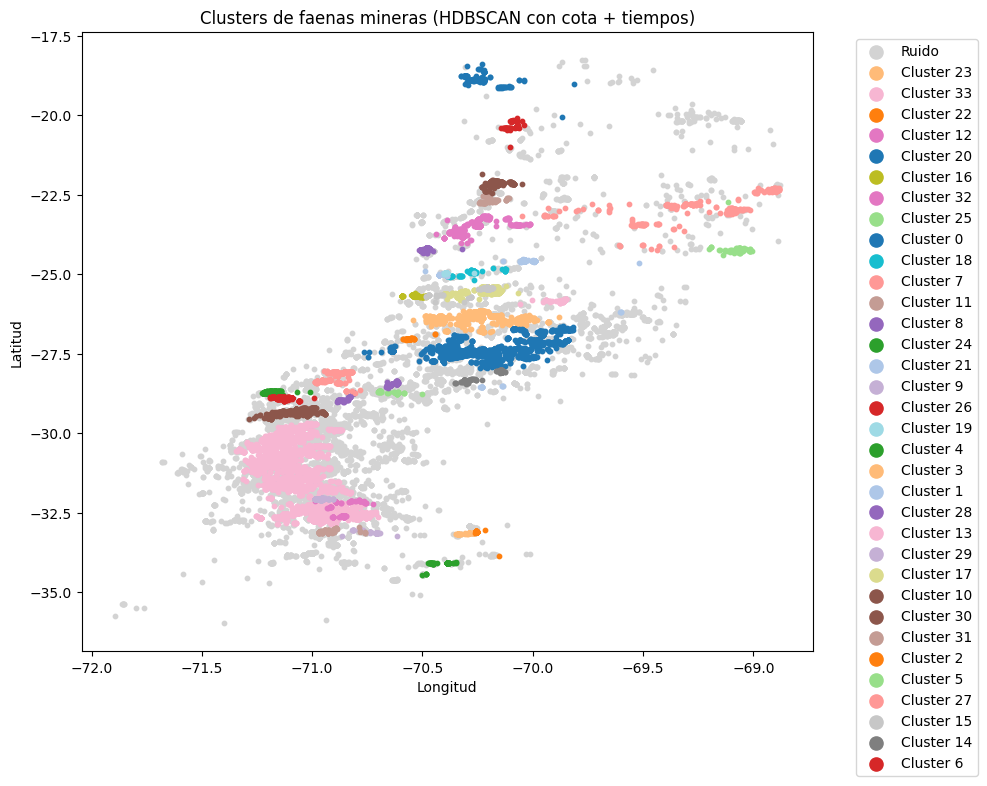

In [39]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 1: Select variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_filtered = df[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_filtered - df_filtered.mean()) / df_filtered.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df.loc[mask].copy()

# === Step 3: Scale the features (important for HDBSCAN) ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 25 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


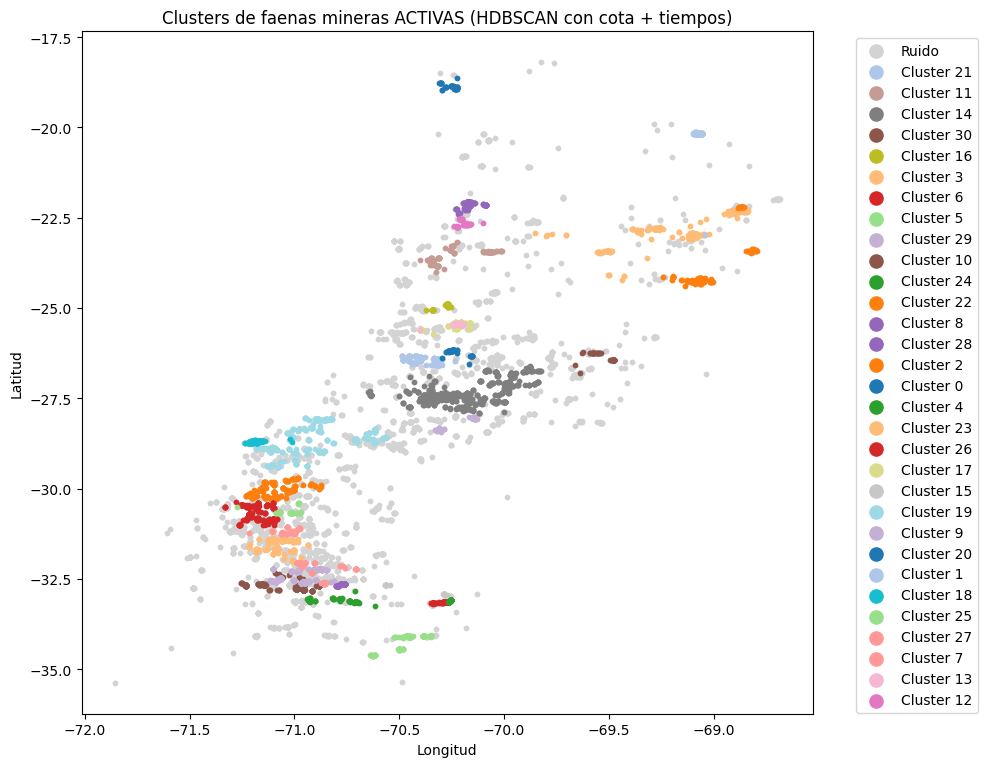

In [40]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.35,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con cota + tiempos)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [41]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")


C:\Users\admin\AppData\Local\Temp\ipykernel_14240\4020827223.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


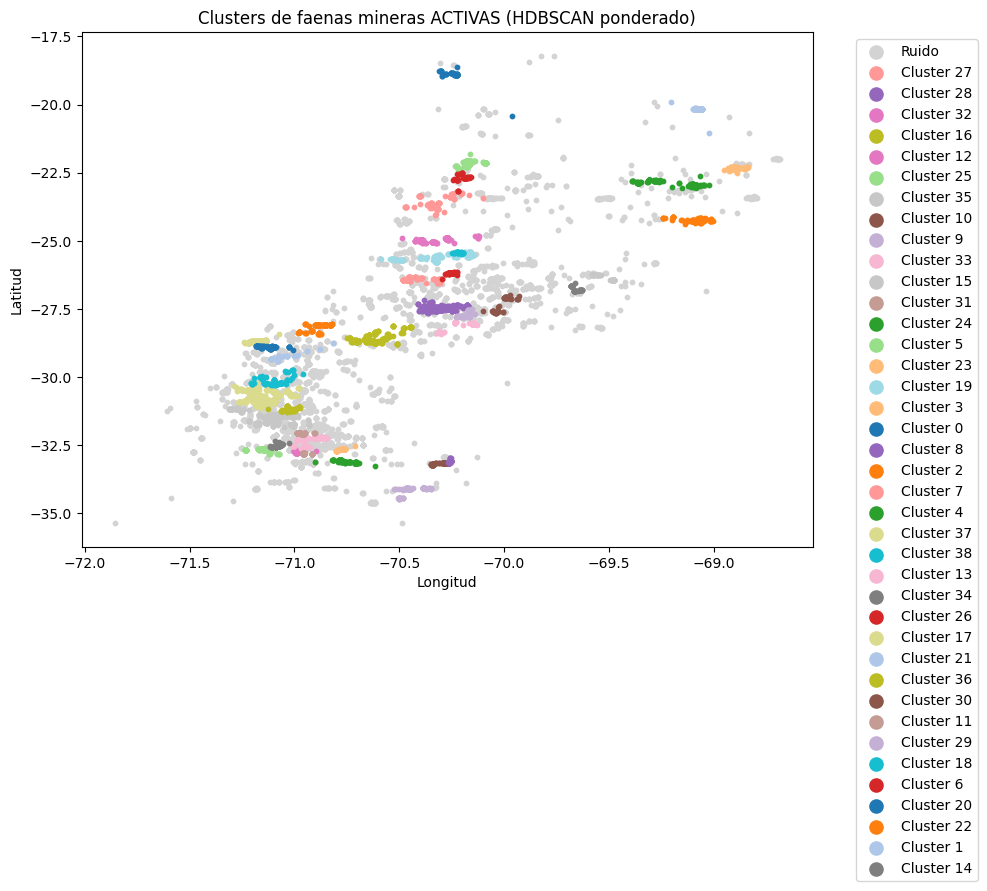

In [42]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filter only active sites ===
df_active = df[df["Estado"] == "ACTIVA"].copy()

# === Step 1: Select relevant variables ===
features = ['Longitud', 'Latitud', 'Cota', 
            'Travel_min', 'travel_time_desal', 'travel_time_min']

# Remove rows with missing or infinite values
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remove outliers using z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Scale and weight features ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Define feature weights (tune as needed)
weights = {
    'Longitud': 3.0,          # keep high (spatial importance)
    'Latitud': 3.0,           # keep high (spatial importance)
    'Cota': 0.5,              # less important
    'Travel_min': 1.5,        # more important
    'travel_time_desal': 0.5, # moderate
    'travel_time_min': 1.0    # baseline
}

# Apply weights
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Fit HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.4,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Keep only top 40 largest clusters ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Plot ===
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('tab20')

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN ponderado)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [43]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\admin\AppData\Local\Temp\ipykernel_14240\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [16]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# === Base map ===
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# === Color map for clusters ===
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % 20)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

# === Add points with popups ===
for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    
    # Create a popup with relevant info
    popup_text = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Travel_min:</b> {row['Travel_min']:.1f} min<br>
    <b>Desaladora:</b> {row['travel_time_desal']:.1f} min<br>
    <b>Puerto:</b> {row['travel_time_min']:.1f} min
    """
    
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# === Save HTML map ===
m.save('chile_clusters.html')
print("✅ Mapa interactivo guardado como chile_clusters.html")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4010231854.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Mapa interactivo guardado como chile_clusters.html


In [44]:
df_faenas2 = pd.read_csv('Cluster/df_faenas_5.csv')

In [45]:
df_faenas2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21158 entries, 0 to 21157
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RutEmpresa          21158 non-null  object 
 1   NombreEmpresa       21158 non-null  object 
 2   CategoriaFaena      21158 non-null  object 
 3   RegionInstalacion   21158 non-null  object 
 4   TipoInstalacion     21158 non-null  object 
 5   Cota                21158 non-null  int64  
 6   Huso                21158 non-null  int64  
 7   Estado              21158 non-null  object 
 8   Latitud             21158 non-null  float64
 9   Longitud            21158 non-null  float64
 10  faenas_10km         21158 non-null  int64  
 11  Cat_A_10km          21158 non-null  int64  
 12  Ciudad_Cercana      21158 non-null  object 
 13  Est_Nombre          21158 non-null  object 
 14  Est_Dist            21158 non-null  float64
 15  Est_Tiempo          21158 non-null  float64
 16  Ciud

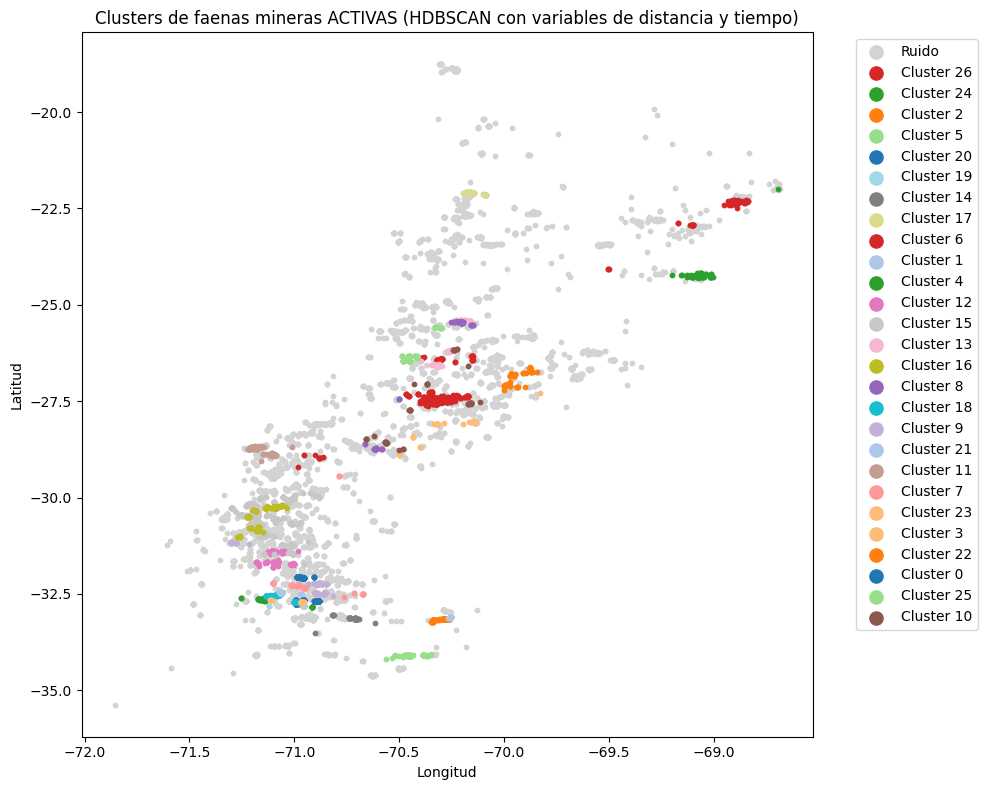

In [22]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Step 0: Filtrar faenas activas ===
df_active = df_faenas2[df_faenas2["Estado"] == "ACTIVA"].copy()

# === Step 1: Seleccionar variables relevantes ===
features = [
    'Longitud', 'Latitud', 'Cota',
     'Ciudad_Tiempo',
    'Est_Dist', 'Est_Tiempo',
    'Desal_Dist_km', 
    'puerto_Tiempo',
    'lt_dist_km'
]

# Eliminar valores faltantes o infinitos
df_active = df_active[features].replace([np.inf, -np.inf], np.nan).dropna().copy()

# === Step 2: Remover outliers mediante Z-score ===
z_scores = np.abs((df_active - df_active.mean()) / df_active.std())
mask = (z_scores < 3).all(axis=1)
df_clean = df_active.loc[mask].copy()

# === Step 3: Escalar y ponderar variables ===
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(df_clean[features])

# ⚖️ Pesos (ajustables según importancia)
weights = {
    'Longitud': 1.0,          # coordenadas espaciales
    'Latitud': 1.0,
    'Cota': 1.0,              # altura menor peso
    'Ciudad_Tiempo': 1.0,
    'Est_Dist': 1.0,          # accesibilidad ferroviaria
    'Est_Tiempo': 3.0,
    'Desal_Dist_km': 1.0,     # acceso hídrico
    'puerto_Tiempo': 1.0,
    'lt_dist_km': 3.0,        # acceso energético
}

# Aplicar pesos
for i, f in enumerate(features):
    coords_scaled[:, i] *= weights[f]

# === Step 4: Clustering con HDBSCAN ===
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=40,
    cluster_selection_epsilon=0.45,
    metric='euclidean'
)
df_clean['cluster'] = clusterer.fit_predict(coords_scaled)

# === Step 5: Mantener los 40 clusters más grandes ===
cluster_counts = df_clean['cluster'].value_counts()
top_clusters = cluster_counts.nlargest(40).index
df_clean['cluster'] = df_clean['cluster'].apply(lambda x: x if x in top_clusters else -1)

# === Step 6: Visualización ===
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap('tab20')  # ✅ nuevo estilo sin warning

for cluster in df_clean['cluster'].unique():
    mask = df_clean['cluster'] == cluster
    if cluster == -1:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color='lightgray', s=10, label='Ruido')
    else:
        plt.scatter(df_clean.loc[mask, 'Longitud'], df_clean.loc[mask, 'Latitud'],
                    color=cmap(cluster % 20), s=10, label=f'Cluster {cluster}')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Clusters de faenas mineras ACTIVAS (HDBSCAN con variables de distancia y tiempo)')
plt.legend(markerscale=3, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [23]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# Assuming df_clean is already defined and populated

# 1. Set the default map to 'OpenStreetMap' to show cities/regions
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='OpenStreetMap')

# 2. Add other tile layers you can switch to
folium.TileLayer(
    'Esri.WorldImagery',
    name='Satellite Imagery'
).add_to(m)

folium.TileLayer(
    'CartoDB positron',
    name='Light Map (Cities/Regions)'
).add_to(m)

# --- Your existing code for clusters ---
num_clusters = len(df_clean['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.to_hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_clean['cluster'].unique()))}

for _, row in df_clean.iterrows():
    cluster_id = row['cluster']
    color = 'lightgray' if cluster_id == -1 else color_dict[cluster_id]
    popup = f"""
    <b>Cluster:</b> {cluster_id}<br>
    <b>Cota:</b> {row['Cota']:.0f}<br>
    <b>Tiempo Ciudad:</b> {row['Ciudad_Tiempo']:.1f} min<br>
    <b>Tiempo Puerto:</b> {row['puerto_Tiempo']:.1f} min<br>
    <b>Dist. Desaladora:</b> {row['Desal_Dist_km']:.1f} km
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=3, color=color, fill=True, fill_opacity=0.8,
        popup=folium.Popup(popup, max_width=250)
    ).add_to(m)
# --- End of your existing code ---

# 3. Add a LayerControl to the map
folium.LayerControl().add_to(m)

# Save the new map (I've updated the name slightly)
m.save('mining_clusters_with_layers.html')
print("🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'")

C:\Users\artur\AppData\Local\Temp\ipykernel_16656\4092962241.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🗺️ Mapa interactivo guardado como 'mining_clusters_with_layers.html'


### Con opti y mas variables

In [58]:
df_faenas2 = pd.read_csv('Cluster/df_faenas_5.csv')

In [4]:
df = df_faenas2
df = df[df['Estado'] == "ACTIVA"]

#### Caso base

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

base_weights = {
    'Longitud': 2.0, 'Latitud': 2.0, 'Cota': 0.7,
    'Ciudad_Tiempo': 1.5, 'Est_Tiempo': 0.8,
    'Desal_Dist_km': 1.0, 'puerto_Tiempo': 0.8, 'lt_tiempo_min': 0.8
}

weight_values = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]

# =====================================
# STEP 2 — CLEAN DATA
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

# --- Agrupar por empresa ---
KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# STEP 4 — GRID SEARCH ON WEIGHTS
# =====================================
results = []

for feature in tqdm(clustering_features, desc="Testing feature weights"):
    for w in weight_values:
        weights = base_weights.copy()
        weights[feature] = w  # vary only one feature at a time

        # Apply weights
        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights[f]

        # --- HDBSCAN clustering ---
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=15,
            min_samples=2,
            cluster_selection_epsilon=0.15,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)

        # --- Compute DBCV ---
        mask = labels != -1
        if mask.sum() > 1 and len(np.unique(labels[mask])) > 1:
            try:
                dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
            except:
                dbcv = np.nan
        else:
            dbcv = np.nan

        results.append({
            'feature': feature,
            'tested_weight': w,
            'dbcv': dbcv,
            'weights': weights,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
        })

# =====================================
# STEP 5 — RESULTS SUMMARY
# =====================================
results_df = pd.DataFrame(results).sort_values('dbcv', ascending=False)
best_result = results_df.iloc[0]

print("\n🏆 === BEST RESULT ===")
print(f"Feature varied: {best_result['feature']}")
print(f"Tested weight: {best_result['tested_weight']}")
print(f"DBCV score: {best_result['dbcv']:.4f}")
print(f"Number of clusters: {best_result['n_clusters']}")
print("\n🔢 Weight configuration:")
for f, w in best_result['weights'].items():
    print(f"  {f}: {w}")

# =====================================
# STEP 6 — OPTIONAL: CLUSTER AGAIN WITH BEST WEIGHTS
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= best_result['weights'][f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)
df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

print("\n✅ Clustering complete with best weights.")
print(df_grouped['cluster'].value_counts())

# Optional: Save results
#results_df.to_csv("weight_search_results.csv", index=False)

✅ Total grouped points: 2281


Testing feature weights: 100%|██████████| 8/8 [00:28<00:00,  3.58s/it]


🏆 === BEST RESULT ===
Feature varied: Latitud
Tested weight: 5.0
DBCV score: 0.1850
Number of clusters: 34

🔢 Weight configuration:
  Longitud: 2.0
  Latitud: 5.0
  Cota: 0.7
  Ciudad_Tiempo: 1.5
  Est_Tiempo: 0.8
  Desal_Dist_km: 1.0
  puerto_Tiempo: 0.8
  lt_tiempo_min: 0.8

✅ Clustering complete with best weights.
cluster
-1     657
 16    451
 15    261
 33    107
 31     68
 26     53
 29     44
 4      42
 10     41
 27     34
 25     33
 23     30
 30     30
 22     28
 13     27
 8      27
 12     25
 6      24
 11     22
 28     22
 32     20
 5      20
 21     18
 0      18
 19     18
 1      17
 9      17
 17     17
 14     17
 20     17
 7      16
 2      15
 18     15
 24     15
 3      15
Name: count, dtype: int64


#### Optimizacion de pesos

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# Target cluster range
TARGET_MIN_CLUSTERS = 30
TARGET_MAX_CLUSTERS = 60

# =====================================
# STEP 2 — CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# STEP 4 — OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    # Suggest weights for each feature
    weights = {
        'Longitud': trial.suggest_float('Longitud', 0.5, 5.0),
        'Latitud': trial.suggest_float('Latitud', 0.5, 5.0),
        'Cota': trial.suggest_float('Cota', 0.5, 2.0),
        'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
        'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
        'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
        'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
        'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
    }

    # Apply weights
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    # Cluster
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=15,
        min_samples=2,
        cluster_selection_epsilon=0.15,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)

    # Compute cluster count
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Skip if no clusters formed
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    # Compute DBCV
    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
    except:
        return -1.0

    # Soft penalty for cluster count deviation
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# STEP 5 — RUN OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# =====================================
# STEP 6 — PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best DBCV (penalized): {study.best_value:.4f}")
print(f"Best weights:")
for k, v in study.best_params.items():
    print(f"  {k}: {v:.2f}")

# =====================================
# STEP 7 — CLUSTER WITH BEST WEIGHTS
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)
df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)
print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(df_grouped['cluster'].value_counts())


[I 2025-11-05 10:11:22,572] A new study created in memory with name: no-name-adbfae88-e876-4d5d-84f8-6905b438df5c


✅ Total grouped points: 2281


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-11-05 10:11:22,987] Trial 0 finished with value: 0.06347098862381848 and parameters: {'Longitud': 1.5289424833594827, 'Latitud': 2.9044058149886243, 'Cota': 0.5899983975186125, 'Ciudad_Tiempo': 0.9814894844295821, 'Est_Tiempo': 1.6345776459020533, 'Desal_Dist_km': 1.2644379630621867, 'puerto_Tiempo': 0.6676833550531738, 'lt_tiempo_min': 1.4224221947994218}. Best is trial 0 with value: 0.06347098862381848.
[I 2025-11-05 10:11:23,310] Trial 1 finished with value: 0.1502740156686291 and parameters: {'Longitud': 3.061442822996942, 'Latitud': 4.711122783832368, 'Cota': 1.6528891714510225, 'Ciudad_Tiempo': 1.9137482071379202, 'Est_Tiempo': 1.7350689406292563, 'Desal_Dist_km': 1.8816651012414778, 'puerto_Tiempo': 1.2021400384566379, 'lt_tiempo_min': 0.5058404493669902}. Best is trial 1 with value: 0.1502740156686291.
[I 2025-11-05 10:11:23,633] Trial 2 finished with value: -0.017559874453039786 and parameters: {'Longitud': 2.223718289527018, 'Latitud': 4.834717339559522, 'Cota': 1.470

In [7]:
# =====================================
# STEP 8 — VISUALIZATION ON CHILE MAP
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# Center of Chile
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# Define colormap
num_clusters = len(df_grouped['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))}

# Add points to map
for _, row in df_grouped.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 250px; height: 180px;
             border:2px solid grey; z-index:9999; font-size:14px; background:white; overflow-y:auto;">
  &nbsp;<b>Cluster Legend</b><br>
  {}
</div>
'''.format("<br>".join([
    f"&nbsp;<i style='background:{color_dict[c]};width:12px;height:12px;display:inline-block;'></i>&nbsp;Cluster {c}"
    for c in sorted(df_grouped['cluster'].unique()) if c != -1
]))
m.get_root().html.add_child(folium.Element(legend_html))

# Save to HTML
m.save("clusters_chile.html")
print("🌎 Map saved as clusters_chile.html — open it in your browser.")


C:\Users\artur\AppData\Local\Temp\ipykernel_14020\1744824247.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Map saved as clusters_chile.html — open it in your browser.


#### Con optimizacion de hdbscan

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# Target cluster range
TARGET_MIN_CLUSTERS = 20
TARGET_MAX_CLUSTERS = 40

# =====================================
# STEP 2 — CLEAN & GROUP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()

KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

# =====================================
# STEP 4 — OPTUNA OBJECTIVE
# =====================================
def objective(trial):
    # --- 1. Feature weights ---
    weights = {
        'Longitud': trial.suggest_float('Longitud', 0.5, 5.0),
        'Latitud': trial.suggest_float('Latitud', 0.5, 5.0),
        'Cota': trial.suggest_float('Cota', 0.5, 2.0),
        'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
        'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
        'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
        'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
        'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
    }

    # --- 2. HDBSCAN hyperparameters ---
    min_cluster_size = trial.suggest_int('min_cluster_size', 5, 50)
    min_samples = trial.suggest_int('min_samples', 1, 15)
    epsilon = trial.suggest_float('cluster_selection_epsilon', 0.0, 0.5)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])

    # --- 3. Apply weights ---
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]

    # --- 4. Run HDBSCAN ---
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon,
        metric=metric
    )
    labels = clusterer.fit_predict(X_weighted)

    # --- 5. Compute cluster count ---
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Skip invalid configurations
    mask = labels != -1
    if mask.sum() <= 1 or n_clusters < 2:
        return -1.0

    # --- 6. Compute DBCV ---
    try:
        dbcv = validity_index(X_weighted[mask], labels[mask], metric=metric)
    except:
        return -1.0

    # --- 7. Soft penalty for cluster count ---
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)

    return dbcv * penalty

# =====================================
# STEP 5 — RUN OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=True)

# =====================================
# STEP 6 — PRINT BEST RESULT
# =====================================
print("\n🏆 === OPTIMIZATION COMPLETE ===")
print(f"Best penalized DBCV: {study.best_value:.4f}")
print("\n🧩 Best parameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# =====================================
# STEP 7 — CLUSTER WITH BEST CONFIG
# =====================================
X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= study.best_params[f]

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=study.best_params['min_cluster_size'],
    min_samples=study.best_params['min_samples'],
    cluster_selection_epsilon=study.best_params['cluster_selection_epsilon'],
    metric=study.best_params['metric']
)
df_grouped['cluster'] = final_clusterer.fit_predict(X_best)

n_clusters_final = len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'].values else 0)
print(f"\n✅ Final number of clusters: {n_clusters_final}")
print(df_grouped['cluster'].value_counts())


[I 2025-11-05 10:12:59,938] A new study created in memory with name: no-name-fee841cd-1e8b-4fc3-99df-950bacc11b46


✅ Total grouped points: 2281


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-05 10:13:00,512] Trial 0 finished with value: -1.0 and parameters: {'Longitud': 4.361386465418166, 'Latitud': 2.901010771675826, 'Cota': 1.8987732739238534, 'Ciudad_Tiempo': 0.8590256065894519, 'Est_Tiempo': 1.4101385443001968, 'Desal_Dist_km': 1.175600201786504, 'puerto_Tiempo': 1.7001611708314508, 'lt_tiempo_min': 1.2048786047341167, 'min_cluster_size': 29, 'min_samples': 9, 'cluster_selection_epsilon': 0.10216628357822888, 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.
[I 2025-11-05 10:13:01,197] Trial 1 finished with value: -1.0 and parameters: {'Longitud': 3.4651216970956535, 'Latitud': 4.078751087557373, 'Cota': 0.7861824319195219, 'Ciudad_Tiempo': 1.3860461899271705, 'Est_Tiempo': 1.50922388474024, 'Desal_Dist_km': 1.7915593048326728, 'puerto_Tiempo': 0.6710686375088439, 'lt_tiempo_min': 1.9096296779309958, 'min_cluster_size': 44, 'min_samples': 14, 'cluster_selection_epsilon': 0.42226581427417365, 'metric': 'manhattan'}. Best is trial 0 with value: -1.0.
[

In [9]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# =====================================
# 1 — Setup base map (Chile)
# =====================================
m = folium.Map(
    location=[-27, -70],
    zoom_start=4.5,
    tiles=None
)

# Satellite and light map layers
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    name="🌍 Satellite"
).add_to(m)

folium.TileLayer(
    "CartoDB positron",
    name="🗺️ Light Map"
).add_to(m)

# =====================================
# 2 — Color setup
# =====================================
num_clusters = len(df_grouped['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {
    c: colors.rgb2hex(cmap(i % cmap.N)) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))
}

# =====================================
# 3 — Add points
# =====================================
for _, row in df_grouped.iterrows():
    cluster = row['cluster']
    color = "#808080" if cluster == -1 else color_dict[cluster]

    popup_text = f"""
    <b>Empresa:</b> {row.get('NombreEmpresa', 'N/A')}<br>
    <b>Cluster:</b> {cluster}<br>
    <b>Faenas:</b> {row.get('FaenasCount', 'N/A')}
    """
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# =====================================
# 4 — Layer control + Save
# =====================================
folium.LayerControl().add_to(m)

# Save to HTML file
output_path = "chile_clusters_map.html"
m.save(output_path)

print(f"✅ Map saved as {output_path}. Open it in your browser!")


C:\Users\artur\AppData\Local\Temp\ipykernel_14020\1890525936.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


✅ Map saved as chile_clusters_map.html. Open it in your browser!


In [10]:
# =====================================
# MULTIVARIATE WEIGHT OPTIMIZATION WITH OPTUNA + HDBSCAN + MAP
# =====================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

WEIGHT_RANGE = (0.2, 5.0)
TARGET_MIN_CLUSTERS = 30
TARGET_MAX_CLUSTERS = 60
RANDOM_STATE = 42  # reproducible

# =====================================
# STEP 2 — DATA PREP
# =====================================
df_clean = df.dropna(subset=clustering_features).copy()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clean[clustering_features])

# =====================================
# STEP 3 — OBJECTIVE FUNCTION
# =====================================
def objective(trial):
    np.random.seed(RANDOM_STATE)
    
    # --- Weights ---
    weights = {}
    for f in clustering_features:
        if f in ["Latitud", "Longitud"]:
            weights[f] = trial.suggest_float(f"w_{f}", 2.0, 5.0)
        else:
            weights[f] = trial.suggest_float(f"w_{f}", WEIGHT_RANGE[0], WEIGHT_RANGE[1])
    
    # --- HDBSCAN parameters (wider ranges) ---
    min_cluster_size = trial.suggest_int("min_cluster_size", 2, 15)  # smaller min size to allow more clusters
    min_samples = trial.suggest_int("min_samples", 1, 10)
    epsilon = trial.suggest_float("cluster_selection_epsilon", 0.0, 1.0)  # wider range
    
    # --- Apply weights ---
    X_weighted = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_weighted[:, i] *= weights[f]
    
    # --- HDBSCAN clustering ---
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=epsilon,
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_weighted)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # --- Calculate DBCV ---
    try:
        dbcv = validity_index(X_weighted, labels, metric='euclidean')
    except Exception:
        dbcv = -1.0
    
    # --- Soft penalty for cluster count ---
    target_mid = (TARGET_MIN_CLUSTERS + TARGET_MAX_CLUSTERS) / 2
    penalty = 1 - abs(n_clusters - target_mid) / target_mid
    penalty = max(penalty, 0)  # ensure non-negative
    
    score = dbcv * penalty
    
    # --- Store extra info ---
    trial.set_user_attr("n_clusters", n_clusters)
    trial.set_user_attr("weights", weights)
    
    return score

# =====================================
# STEP 4 — OPTUNA OPTIMIZATION
# =====================================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, show_progress_bar=False)

# =====================================
# STEP 5 — SHOW TOP 5 TRIALS
# =====================================
print("\n🏆 === TOP 5 TRIALS BY SCORE ===")
sorted_trials = sorted(study.trials, key=lambda t: t.value if t.value is not None else -1, reverse=True)[:5]

results = []
for i, trial in enumerate(sorted_trials, start=1):
    val = trial.value
    n_clusters = trial.user_attrs.get("n_clusters", None)
    weights = trial.user_attrs.get("weights", {})
    print(f"\n🔹 Rank {i}")
    print(f"   Trial #{trial.number}")
    print(f"   Score: {val:.4f}")
    print(f"   Clusters: {n_clusters}")
    for k, v in weights.items():
        print(f"     {k}: {v:.3f}")
    results.append({
        "Rank": i,
        "Trial": trial.number,
        "Score": val,
        "Clusters": n_clusters,
        **weights
    })

df_results = pd.DataFrame(results)
print("\n=== SUMMARY TABLE ===")
print(df_results)

# =====================================
# STEP 6 — FINAL BEST MODEL
# =====================================
best_trial = study.best_trial
best_weights = {f: best_trial.params[f"w_{f}"] for f in clustering_features}

X_best = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_best[:, i] *= best_weights[f]

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_trial.params["min_cluster_size"],
    min_samples=best_trial.params["min_samples"],
    cluster_selection_epsilon=best_trial.params["cluster_selection_epsilon"],
    metric='euclidean'
)
final_labels = clusterer.fit_predict(X_best)
df_clean["cluster"] = final_labels

print(f"\n✅ Final model: {len(set(final_labels)) - (1 if -1 in final_labels else 0)} clusters.")



[I 2025-11-05 10:14:35,996] A new study created in memory with name: no-name-74d8f488-9339-48d5-bcc5-202989f5b302
[I 2025-11-05 10:14:42,516] Trial 0 finished with value: 0.0 and parameters: {'w_Longitud': 3.5298691475172976, 'w_Latitud': 2.5741084497589894, 'w_Cota': 3.541600416432225, 'w_Ciudad_Tiempo': 4.530007637631496, 'w_Est_Tiempo': 3.3543024093843106, 'w_Desal_Dist_km': 0.45393516985695914, 'w_puerto_Tiempo': 4.29215584379528, 'w_lt_tiempo_min': 3.072219591761302, 'min_cluster_size': 10, 'min_samples': 9, 'cluster_selection_epsilon': 0.20503089128757057}. Best is trial 0 with value: 0.0.
[I 2025-11-05 10:14:53,634] Trial 1 finished with value: 0.0 and parameters: {'w_Longitud': 4.831805112324448, 'w_Latitud': 2.780463877746259, 'w_Cota': 0.5115200688316079, 'w_Ciudad_Tiempo': 0.648419257121585, 'w_Est_Tiempo': 2.669612658733088, 'w_Desal_Dist_km': 2.530798279147908, 'w_puerto_Tiempo': 1.6158276705659136, 'w_lt_tiempo_min': 3.5334278569670983, 'min_cluster_size': 6, 'min_samples

KeyboardInterrupt: 

In [ ]:
# =====================================
# STEP 7 — MAP VISUALIZATION
# =====================================
num_clusters = df_grouped['cluster'].nunique()
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i % 20)[:3]) for i, c in enumerate(sorted(df_grouped['cluster'].unique()))}

m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

for _, row in df_grouped.iterrows():
    if row['cluster'] == -1:
        continue
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color_dict[row['cluster']],
        fill=True,
        fill_opacity=0.8,
        popup=f"Empresa: {row['NombreEmpresa']}<br>Cluster: {row['cluster']}"
    ).add_to(m)

output_file = "clusters_chile.html"
m.save(output_file)
print(f"\n🌎 Map saved as {output_file}")


C:\Users\admin\AppData\Local\Temp\ipykernel_16804\1340619203.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)



🌎 Map saved as clusters_chile.html


#### Separacion del pais

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
import hdbscan
from hdbscan.validity import validity_index
import optuna
from tqdm import tqdm
import joblib

# =====================================
# STEP 0 — REGIONES NORTE / CENTRO-SUR
# =====================================
norte_regiones = ['ARICA Y PARINACOTA', 'TARAPACA', 'ANTOFAGASTA', 'ATACAMA']
centro_sur_regiones = [
    'COQUIMBO', 'VALPARAISO', 'METROPOLITANA DE SANTIAGO',
    'LIBERTADOR GENERAL BERNARDO OHIGGINS', 'MAULE', 'MAGALLANES Y DE LA ANTARTICA CHILENA'
]

north_df = df[df['RegionInstalacion'].isin(norte_regiones)].copy()
south_df = df[df['RegionInstalacion'].isin(centro_sur_regiones)].copy()

print(f"Puntos norte: {len(north_df)}, puntos centro-sur: {len(south_df)}")

# =====================================
# STEP 1 — FEATURES
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# =====================================
# STEP 2 — AGRUPAR POR EMPRESA
# =====================================
def group_by_empresa(df_region):
    KM_RADIUS = 1.0
    EARTH_RADIUS_KM = 6371
    eps_rad = KM_RADIUS / EARTH_RADIUS_KM

    dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
    grouped_points = []

    for empresa, group in df_region.groupby("NombreEmpresa"):
        coords_rad = np.radians(group[['Latitud', 'Longitud']])
        sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
        group['sub_cluster'] = sub_cluster_labels

        for label, subset in group.groupby('sub_cluster'):
            row = subset.mean(numeric_only=True).to_dict()
            row["NombreEmpresa"] = empresa
            row["FaenasCount"] = len(subset)
            grouped_points.append(row)
    return pd.DataFrame(grouped_points)

north_grouped = group_by_empresa(north_df)
south_grouped = group_by_empresa(south_df)

print(f"Grouped North points: {len(north_grouped)}, Grouped Central-South points: {len(south_grouped)}")

# =====================================
# STEP 3 — SCALING
# =====================================
scaler_north = RobustScaler()
X_north_scaled = scaler_north.fit_transform(north_grouped[clustering_features])

scaler_south = RobustScaler()
X_south_scaled = scaler_south.fit_transform(south_grouped[clustering_features])

# =====================================
# STEP 4 — OBJETIVO OPTUNA
# =====================================
TARGET_MIN_CLUSTERS = 15
TARGET_MAX_CLUSTERS = 40

def make_objective(X_scaled, min_cluster_size_range, min_samples_range, target_min=TARGET_MIN_CLUSTERS, target_max=TARGET_MAX_CLUSTERS):
    def objective(trial):
        weights = {
            'Longitud': trial.suggest_float('Longitud', 2.0, 5.0),
            'Latitud': trial.suggest_float('Latitud', 2.0, 5.0),
            'Cota': trial.suggest_float('Cota', 0.5, 2.0),
            'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
            'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
            'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
            'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
            'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
        }

        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights[f]

        min_cluster_size = trial.suggest_int("min_cluster_size", min_cluster_size_range[0], min_cluster_size_range[1])
        min_samples = trial.suggest_int("min_samples", min_samples_range[0], min_samples_range[1])
        epsilon = trial.suggest_float("cluster_selection_epsilon", 0.05, 0.25)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        mask = labels != -1
        if mask.sum() <= 1 or n_clusters < 2:
            return -1.0

        try:
            dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
        except:
            return -1.0

        target_mid = (target_min + target_max) / 2
        penalty = 1 - abs(n_clusters - target_mid) / target_mid
        penalty = max(penalty, 0)
        return dbcv * penalty
    return objective

# =====================================
# STEP 5 — OPTIMIZACIÓN POR REGIÓN
# =====================================
def optimize_region(X_scaled, min_cluster_size_range, min_samples_range, n_trials=150):
    study = optuna.create_study(direction="maximize")
    study.optimize(make_objective(X_scaled, min_cluster_size_range, min_samples_range), n_trials=n_trials, show_progress_bar=True)
    return study

# Norte: min_cluster_size más bajo, min_samples más bajo
north_study = optimize_region(X_north_scaled, min_cluster_size_range=(20,30), min_samples_range=(1,2), n_trials=150)
# Centro-Sur: parámetros estándar
south_study = optimize_region(X_south_scaled, min_cluster_size_range=(18,23), min_samples_range=(3,4), n_trials=150)



# =====================================
# STEP 6 — CLUSTER CON MEJORES PESOS + DBCV
# =====================================
def cluster_best(X_scaled, study, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(clustering_features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)

    # Compute DBCV only for valid points
    mask = labels != -1
    if mask.sum() > 1 and len(set(labels[mask])) > 1:
        dbcv_score = validity_index(X_best[mask], labels[mask], metric='euclidean')
    else:
        dbcv_score = -1.0

    # Save the model
    model_path = f"hdbscan_{name}_best_model.pkl"
    joblib.dump(clusterer, model_path)

    print(f"✅ {name.upper()} best model saved to {model_path}")
    print(f"🏅 {name.upper()} DBCV score: {dbcv_score:.4f}")
    print(f"📦 {name.upper()} clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    return labels, dbcv_score

north_grouped['cluster'], dbcv_north = cluster_best(X_north_scaled, north_study, name="north")
south_grouped['cluster'], dbcv_south = cluster_best(X_south_scaled, south_study, name="south")

print("\n📊 Summary of models:")
print(f"   • Northern DBCV: {dbcv_north:.4f}")
print(f"   • Central–South DBCV: {dbcv_south:.4f}")

# =====================================
# STEP 7 — COMBINAR AMBOS REGISTROS
# =====================================
df_final = pd.concat([north_grouped, south_grouped], ignore_index=True)
print(f"✅ Total clusters combinados: {df_final['cluster'].nunique()}")

# =====================================
# STEP 8 — MAPA INTERACTIVO (unchanged)
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

num_clusters = len(df_final['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_final['cluster'].unique()))}

for _, row in df_final.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

# Leyenda
legend_html = '''
<div style="position: fixed; bottom: 30px; left: 30px; width: 250px; height: 180px;
             border:2px solid grey; z-index:9999; font-size:14px; background:white; overflow-y:auto;">
  &nbsp;<b>Cluster Legend</b><br>
  {}
</div>
'''.format("<br>".join([
    f"&nbsp;<i style='background:{color_dict[c]};width:12px;height:12px;display:inline-block;'></i>&nbsp;Cluster {c}"
    for c in sorted(df_final['cluster'].unique()) if c != -1
]))
m.get_root().html.add_child(folium.Element(legend_html))

m.save("clusters_chile_dual_models.html")
print("🌎 Mapa guardado como clusters_chile_dual_models.html")



Puntos norte: 4012, puntos centro-sur: 3905


[I 2025-11-05 10:51:10,933] A new study created in memory with name: no-name-0b2d8670-b22a-49c9-b38c-12b1ae785ded


Grouped North points: 1385, Grouped Central-South points: 896


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-05 10:51:11,353] Trial 0 finished with value: -0.03075619648473477 and parameters: {'Longitud': 2.9183358517839584, 'Latitud': 3.718194189399145, 'Cota': 1.8379234089507193, 'Ciudad_Tiempo': 1.2506048396437115, 'Est_Tiempo': 1.7884473639418814, 'Desal_Dist_km': 1.8487251073486606, 'puerto_Tiempo': 0.8221889760316516, 'lt_tiempo_min': 0.6295453293708666, 'min_cluster_size': 30, 'min_samples': 2, 'cluster_selection_epsilon': 0.13867032912496946}. Best is trial 0 with value: -0.03075619648473477.
[I 2025-11-05 10:51:11,507] Trial 1 finished with value: 0.09142300783788507 and parameters: {'Longitud': 3.7962517536704414, 'Latitud': 3.0579939199531476, 'Cota': 1.0964173283466212, 'Ciudad_Tiempo': 1.4607241191139226, 'Est_Tiempo': 1.0329584495767508, 'Desal_Dist_km': 1.6991887356178286, 'puerto_Tiempo': 0.7040746065009178, 'lt_tiempo_min': 1.447447305161527, 'min_cluster_size': 20, 'min_samples': 1, 'cluster_selection_epsilon': 0.21741264163647916}. Best is trial 1 with value: 0.0

[I 2025-11-05 10:51:45,836] A new study created in memory with name: no-name-e3038f7e-04e3-4489-9ef9-4c6d9e0189c4


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-05 10:51:45,960] Trial 0 finished with value: -0.009903945807609688 and parameters: {'Longitud': 4.81343591932559, 'Latitud': 2.5031916869487665, 'Cota': 1.6904610838543643, 'Ciudad_Tiempo': 1.3656749129039851, 'Est_Tiempo': 1.9201446382497678, 'Desal_Dist_km': 0.7321535659757538, 'puerto_Tiempo': 1.8949511992048593, 'lt_tiempo_min': 1.8600286263830366, 'min_cluster_size': 23, 'min_samples': 4, 'cluster_selection_epsilon': 0.07906605282891505}. Best is trial 0 with value: -0.009903945807609688.
[I 2025-11-05 10:51:46,086] Trial 1 finished with value: -0.011328438443889458 and parameters: {'Longitud': 2.377613191230936, 'Latitud': 4.239430268463288, 'Cota': 0.6607330870343469, 'Ciudad_Tiempo': 1.3575156062375173, 'Est_Tiempo': 1.6501046171972606, 'Desal_Dist_km': 1.4506669326835764, 'puerto_Tiempo': 0.8885559963405318, 'lt_tiempo_min': 1.0239364343901514, 'min_cluster_size': 23, 'min_samples': 3, 'cluster_selection_epsilon': 0.18478071779345567}. Best is trial 0 with value: -

C:\Users\artur\AppData\Local\Temp\ipykernel_14020\1678660462.py:193: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Mapa guardado como clusters_chile_dual_models.html


#### Coquimbo y valpo

In [62]:
# =====================================
# STEP 0 — FIX REGION MISLABELS USING LATITUDE
# =====================================

# Normalize region names
df['RegionInstalacion'] = df['RegionInstalacion'].str.upper().str.strip()

# Identify Metropolitana points that are actually north (i.e., Valparaíso zone)
mask_wrong_north = (df['RegionInstalacion'] == 'METROPOLITANA DE SANTIAGO') & (df['Latitud'] > -33)

# Reassign them
df.loc[mask_wrong_north, 'RegionInstalacion'] = 'VALPARAISO'

print(f"🔧 Corrected {mask_wrong_north.sum()} northern Metropolitana points → Valparaíso based on latitude.")


🔧 Corrected 0 northern Metropolitana points → Valparaíso based on latitude.


In [64]:
# =====================================
# COQUIMBO+VALPARAÍSO VS REST — FLEXIBLE RANGES PER REGION
# =====================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import hdbscan
from hdbscan.validity import validity_index
import optuna
import joblib
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# =====================================
# SPLIT REGIONS
# =====================================
coqvalpo_regiones = ['COQUIMBO', 'VALPARAISO']
coqvalpo_df = df[df['RegionInstalacion'].isin(coqvalpo_regiones)].copy()
rest_df = df[~df['RegionInstalacion'].isin(coqvalpo_regiones)].copy()

print(f"Puntos Coquimbo+Valparaíso: {len(coqvalpo_df)}, resto del país: {len(rest_df)}")

# =====================================
# FEATURES
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'lt_tiempo_min', 'puerto_Tiempo'  
]


# =====================================
# GROUP BY EMPRESA
# =====================================
from sklearn.cluster import DBSCAN

def group_by_empresa(df_region):
    KM_RADIUS = 1.65
    EARTH_RADIUS_KM = 6371
    eps_rad = KM_RADIUS / EARTH_RADIUS_KM

    dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
    grouped_points = []

    for empresa, group in df_region.groupby("NombreEmpresa"):
        coords_rad = np.radians(group[['Latitud', 'Longitud']])
        sub_labels = dbscan_grouper.fit_predict(coords_rad)
        group['sub_cluster'] = sub_labels

        for label, subset in group.groupby('sub_cluster'):
            row = subset.mean(numeric_only=True).to_dict()
            row["NombreEmpresa"] = empresa
            row["FaenasCount"] = len(subset)
            grouped_points.append(row)

    return pd.DataFrame(grouped_points)

coqvalpo_grouped = group_by_empresa(coqvalpo_df)
rest_grouped = group_by_empresa(rest_df)

# =====================================
# SCALING
# =====================================
scaler_coq = RobustScaler()
X_coq_scaled = scaler_coq.fit_transform(coqvalpo_grouped[clustering_features])

scaler_rest = RobustScaler()
X_rest_scaled = scaler_rest.fit_transform(rest_grouped[clustering_features])

# =====================================
# OBJECTIVE FACTORY
# =====================================
def make_objective(X_scaled, clustering_features, target_min, target_max,
                   min_cluster_size_range, min_samples_range):
    """Creates a flexible Optuna objective function."""
    def objective(trial):
        weights = {
            'Longitud': trial.suggest_float('Longitud', 2.0, 5.0),
            'Latitud': trial.suggest_float('Latitud', 2.0, 5.0),
            'Cota': trial.suggest_float('Cota', 0.5, 2.0),
            'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 2.0),
            'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.0),
            'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 2.0),
            'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 2.0),
            'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.0),
        }

        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights[f]

        min_cluster_size = trial.suggest_int("min_cluster_size",
                                             min_cluster_size_range[0],
                                             min_cluster_size_range[1])
        min_samples = trial.suggest_int("min_samples",
                                        min_samples_range[0],
                                        min_samples_range[1])
        epsilon = trial.suggest_float("cluster_selection_epsilon", 0.05, 0.4)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        mask = labels != -1
        if mask.sum() <= 1 or n_clusters < 2:
            return -1.0

        try:
            dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
        except:
            return -1.0

        target_mid = (target_min + target_max) / 2
        penalty = 1 - abs(n_clusters - target_mid) / target_mid
        penalty = max(penalty, 0)
        return dbcv * penalty
    return objective

# =====================================
# OPTIMIZATION FUNCTION
# =====================================
def optimize_region(X_scaled, features, region_name,
                    target_range, min_cluster_size_range, min_samples_range,
                    n_trials=100):
    print(f"\n🔍 Optimizing {region_name} | Target clusters {target_range} | "
          f"min_cluster_size {min_cluster_size_range} | min_samples {min_samples_range}")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        make_objective(X_scaled, features, *target_range,
                       min_cluster_size_range, min_samples_range),
        n_trials=n_trials,
        show_progress_bar=True
    )
    return study

# =====================================
# RUN OPTIMIZATION
# =====================================
coqvalpo_study = optimize_region(
    X_coq_scaled, clustering_features, "Coquimbo+Valparaíso",
    target_range=(3, 6),
    min_cluster_size_range=(15, 25),
    min_samples_range=(3, 6),
    n_trials=400
)

rest_study = optimize_region(
    X_rest_scaled, clustering_features, "Rest of Chile",
    target_range=(15, 25),
    min_cluster_size_range=(30, 40),
    min_samples_range=(1, 3),
    n_trials=600
)

# =====================================
# APPLY BEST MODEL
# =====================================
def cluster_best(X_scaled, study, features, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)

    mask = labels != -1
    if mask.sum() > 1 and len(set(labels[mask])) > 1:
        dbcv_score = validity_index(X_best[mask], labels[mask], metric='euclidean')
    else:
        dbcv_score = -1.0

    joblib.dump(clusterer, f"hdbscan_{name}_best_model.pkl")

    print(f"\n✅ {name.upper()} model saved: hdbscan_{name}_best_model.pkl")
    print(f"🏅 {name.upper()} DBCV score: {dbcv_score:.4f}")
    print(f"📦 {name.upper()} clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    return labels, dbcv_score

coqvalpo_grouped['cluster'], dbcv_coqvalpo = cluster_best(X_coq_scaled, coqvalpo_study, clustering_features, "coq_valpo")
rest_grouped['cluster'], dbcv_rest = cluster_best(X_rest_scaled, rest_study, clustering_features, "rest")

# =====================================
# COMBINE RESULTS
# =====================================
df_final = pd.concat([coqvalpo_grouped, rest_grouped], ignore_index=True)
print("\n📊 Summary:")
print(f"• Coquimbo+Valparaíso DBCV: {dbcv_coqvalpo:.4f}")
print(f"• Rest of Chile DBCV: {dbcv_rest:.4f}")
print(f"✅ Total clusters combinados: {df_final['cluster'].nunique()}")

# =====================================
# MAP
# =====================================
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')
num_clusters = len(df_final['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_final['cluster'].unique()))}

for _, row in df_final.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

m.save("clusters_chile_flexible_ranges.html")
print("🌎 Mapa guardado como clusters_chile_flexible_ranges.html")



Puntos Coquimbo+Valparaíso: 3352, resto del país: 4565


[I 2025-11-05 15:39:09,522] A new study created in memory with name: no-name-7d0c68f9-13e3-4a91-b099-1ebde3483590



🔍 Optimizing Coquimbo+Valparaíso | Target clusters (3, 6) | min_cluster_size (15, 25) | min_samples (3, 6)


  0%|          | 0/400 [00:00<?, ?it/s]

[I 2025-11-05 15:39:09,647] Trial 0 finished with value: 0.05204487271338303 and parameters: {'Longitud': 4.426419202577571, 'Latitud': 4.541325869058279, 'Cota': 0.7867235042300125, 'Ciudad_Tiempo': 0.6325633910906184, 'Est_Tiempo': 0.5747362418099086, 'Desal_Dist_km': 1.1457973474508205, 'puerto_Tiempo': 0.6413648880041826, 'lt_tiempo_min': 0.8695944937434522, 'min_cluster_size': 22, 'min_samples': 5, 'cluster_selection_epsilon': 0.17810824291637006}. Best is trial 0 with value: 0.05204487271338303.
[I 2025-11-05 15:39:09,766] Trial 1 finished with value: 0.01772594182786966 and parameters: {'Longitud': 2.1966335718604295, 'Latitud': 2.1076909679817635, 'Cota': 0.5405557553737584, 'Ciudad_Tiempo': 0.5495186682042533, 'Est_Tiempo': 1.523813772221963, 'Desal_Dist_km': 1.7348439369276354, 'puerto_Tiempo': 0.9122030856823535, 'lt_tiempo_min': 1.291132711469756, 'min_cluster_size': 19, 'min_samples': 6, 'cluster_selection_epsilon': 0.16360765172526093}. Best is trial 0 with value: 0.05204

[I 2025-11-05 15:40:22,240] A new study created in memory with name: no-name-c5179375-4492-4fb4-834d-bd95562e64e6


[I 2025-11-05 15:40:22,086] Trial 398 finished with value: 0.14472851374456777 and parameters: {'Longitud': 2.1037664989304052, 'Latitud': 4.9310293020004785, 'Cota': 1.018110552627775, 'Ciudad_Tiempo': 1.9758625880481508, 'Est_Tiempo': 0.5589860829780874, 'Desal_Dist_km': 1.4689189070572972, 'puerto_Tiempo': 1.761773314118528, 'lt_tiempo_min': 1.0903951194554, 'min_cluster_size': 24, 'min_samples': 6, 'cluster_selection_epsilon': 0.21794972622901773}. Best is trial 165 with value: 0.21029440943732314.
[I 2025-11-05 15:40:22,237] Trial 399 finished with value: 0.15583199459164365 and parameters: {'Longitud': 2.1420453364145375, 'Latitud': 4.997364469377645, 'Cota': 1.0309817566690578, 'Ciudad_Tiempo': 1.9276730996023876, 'Est_Tiempo': 0.5009663970988032, 'Desal_Dist_km': 1.5049334448877627, 'puerto_Tiempo': 1.7867670088830518, 'lt_tiempo_min': 1.3562651804639365, 'min_cluster_size': 23, 'min_samples': 6, 'cluster_selection_epsilon': 0.20437385464532096}. Best is trial 165 with value: 0

  0%|          | 0/600 [00:00<?, ?it/s]

[I 2025-11-05 15:40:22,618] Trial 0 finished with value: -0.031177323799631826 and parameters: {'Longitud': 3.2981984204068624, 'Latitud': 3.5832976590058228, 'Cota': 1.297733909106156, 'Ciudad_Tiempo': 1.9958222803129697, 'Est_Tiempo': 0.8815915803398051, 'Desal_Dist_km': 1.662280148562775, 'puerto_Tiempo': 1.2314821827543008, 'lt_tiempo_min': 1.7456830823255385, 'min_cluster_size': 33, 'min_samples': 2, 'cluster_selection_epsilon': 0.349293149637163}. Best is trial 0 with value: -0.031177323799631826.
[I 2025-11-05 15:40:23,053] Trial 1 finished with value: -0.015508881554966982 and parameters: {'Longitud': 4.290712446579747, 'Latitud': 4.9927340566499385, 'Cota': 1.330565502655765, 'Ciudad_Tiempo': 0.732258173909025, 'Est_Tiempo': 1.2897550744987243, 'Desal_Dist_km': 1.0052912858609462, 'puerto_Tiempo': 0.6703038605881406, 'lt_tiempo_min': 1.152127159400329, 'min_cluster_size': 38, 'min_samples': 3, 'cluster_selection_epsilon': 0.2996634399778876}. Best is trial 1 with value: -0.015

C:\Users\artur\AppData\Local\Temp\ipykernel_14020\3390258993.py:210: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Mapa guardado como clusters_chile_flexible_ranges.html


In [89]:
# =====================================
# SPLIT REGIONAL: NORTE / ATACAMA / COQUIMBO / SUR
# =====================================

df['RegionInstalacion'] = df['RegionInstalacion'].str.upper().str.strip()

norte_regiones = ['ANTOFAGASTA', 'ARICA Y PARINACOTA', 'TARAPACA']
atacama_regiones = ['ATACAMA']
coquimbo_regiones = ['COQUIMBO']
sur_regiones = [
    'VALPARAISO',
    'METROPOLITANA DE SANTIAGO',
    'LIBERTADOR GENERAL BERNARDO OHIGGINS',
    'MAULE'
]

mask_norte = df['RegionInstalacion'].isin(norte_regiones)
mask_atacama = df['RegionInstalacion'].isin(atacama_regiones)
mask_coquimbo = df['RegionInstalacion'].isin(coquimbo_regiones)
mask_sur = df['RegionInstalacion'].isin(sur_regiones)

df_norte = df[mask_norte].copy()
df_atacama = df[mask_atacama].copy()
df_coquimbo = df[mask_coquimbo].copy()
df_sur = df[mask_sur].copy()

print(f"🟠 Norte (Antofagasta, Arica, Tarapacá): {df_norte.shape[0]} faenas")
print(f"🟣 Atacama: {df_atacama.shape[0]} faenas")
print(f"🟢 Coquimbo: {df_coquimbo.shape[0]} faenas")
print(f"🔵 Sur (Valparaíso, RM, O’Higgins, Maule): {df_sur.shape[0]} faenas")

regiones_incluidas = norte_regiones + atacama_regiones + coquimbo_regiones + sur_regiones
regiones_faltantes = sorted(set(df['RegionInstalacion']) - set(regiones_incluidas))
if regiones_faltantes:
    print(f"⚠️ Regiones no asignadas a ningún grupo: {regiones_faltantes}")


# =====================================
# FEATURES
# =====================================

clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'lt_tiempo_min', 'puerto_Tiempo'
]


# =====================================
# GROUP BY EMPRESA (DBSCAN haversine)
# =====================================

def group_by_empresa(df_region):
    KM_RADIUS = 1.75
    EARTH_RADIUS_KM = 6371
    eps_rad = KM_RADIUS / EARTH_RADIUS_KM

    dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')
    grouped_points = []

    for empresa, group in df_region.groupby("NombreEmpresa"):
        coords_rad = np.radians(group[['Latitud', 'Longitud']])
        sub_labels = dbscan_grouper.fit_predict(coords_rad)
        group['sub_cluster'] = sub_labels

        for label, subset in group.groupby('sub_cluster'):
            row = subset.mean(numeric_only=True).to_dict()
            row["NombreEmpresa"] = empresa
            row["FaenasCount"] = len(subset)
            grouped_points.append(row)

    return pd.DataFrame(grouped_points)

norte_grouped = group_by_empresa(df_norte)
atacama_grouped = group_by_empresa(df_atacama)
coquimbo_grouped = group_by_empresa(df_coquimbo)
sur_grouped = group_by_empresa(df_sur)


# =====================================
# SCALING
# =====================================

scaler = RobustScaler()

X_norte_scaled = scaler.fit_transform(norte_grouped[clustering_features])
X_atacama_scaled = scaler.fit_transform(atacama_grouped[clustering_features])
X_coquimbo_scaled = scaler.fit_transform(coquimbo_grouped[clustering_features])
X_sur_scaled = scaler.fit_transform(sur_grouped[clustering_features])


# =====================================
# OBJECTIVE FACTORY (Optuna)
# =====================================

def make_objective(X_scaled, clustering_features, target_min, target_max,
                   min_cluster_size_range, min_samples_range):
    def objective(trial):
        weights = {
            'Longitud': trial.suggest_float('Longitud', 2.0, 5.5),
            'Latitud': trial.suggest_float('Latitud', 2.0, 5.5),
            'Cota': trial.suggest_float('Cota', 0.5, 2.5),
            'Ciudad_Tiempo': trial.suggest_float('Ciudad_Tiempo', 0.5, 3.0),
            'Est_Tiempo': trial.suggest_float('Est_Tiempo', 0.5, 2.5),
            'Desal_Dist_km': trial.suggest_float('Desal_Dist_km', 0.5, 3.0),
            'puerto_Tiempo': trial.suggest_float('puerto_Tiempo', 0.5, 3.0),
            'lt_tiempo_min': trial.suggest_float('lt_tiempo_min', 0.5, 2.5),
        }

        X_weighted = X_scaled.copy()
        for i, f in enumerate(clustering_features):
            X_weighted[:, i] *= weights.get(f, 1.0)

        min_cluster_size = trial.suggest_int("min_cluster_size",
                                             *min_cluster_size_range)
        min_samples = trial.suggest_int("min_samples", *min_samples_range)
        epsilon = trial.suggest_float("cluster_selection_epsilon", 0.05, 0.4)

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            metric='euclidean'
        )
        labels = clusterer.fit_predict(X_weighted)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        mask = labels != -1
        if mask.sum() <= 1 or n_clusters < 2:
            return -1.0

        try:
            dbcv = validity_index(X_weighted[mask], labels[mask], metric='euclidean')
        except Exception:
            return -1.0

        target_mid = (target_min + target_max) / 2
        penalty = 1 - abs(n_clusters - target_mid) / target_mid
        return dbcv * max(penalty, 0)
    return objective


# =====================================
# OPTIMIZATION WRAPPER
# =====================================

def optimize_region(X_scaled, features, region_name,
                    target_range, min_cluster_size_range, min_samples_range,
                    n_trials=150):
    print(f"\n🔍 Optimizing {region_name} | Target clusters {target_range} | "
          f"min_cluster_size {min_cluster_size_range} | min_samples {min_samples_range}")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        make_objective(X_scaled, features, *target_range,
                       min_cluster_size_range, min_samples_range),
        n_trials=n_trials,
        show_progress_bar=True
    )
    return study


# =====================================
# RUN OPTIMIZATION
# =====================================

norte_study = optimize_region(
    X_norte_scaled, clustering_features, "Norte",
    target_range=(4, 9),
    min_cluster_size_range=(18, 25),
    min_samples_range=(3, 5),
    n_trials=400
)

atacama_study = optimize_region(
    X_atacama_scaled, clustering_features, "Atacama",
    target_range=(3, 6),
    min_cluster_size_range=(23, 30),
    min_samples_range=(2, 5),
    n_trials=400
)

coquimbo_study = optimize_region(
    X_coquimbo_scaled, clustering_features, "Coquimbo",
    target_range=(4, 7),
    min_cluster_size_range=(27, 35),
    min_samples_range=(3, 6),
    n_trials=400
)

sur_study = optimize_region(
    X_sur_scaled, clustering_features, "Sur",
    target_range=(5, 10),
    min_cluster_size_range=(8, 15),
    min_samples_range=(3, 5),
    n_trials=500
)


# =====================================
# CLUSTER BEST MODELS
# =====================================

def cluster_best(X_scaled, study, features, name="region"):
    X_best = X_scaled.copy()
    for i, f in enumerate(features):
        X_best[:, i] *= study.best_params[f]

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=study.best_params["min_cluster_size"],
        min_samples=study.best_params["min_samples"],
        cluster_selection_epsilon=study.best_params["cluster_selection_epsilon"],
        metric='euclidean'
    )
    labels = clusterer.fit_predict(X_best)
    mask = labels != -1
    dbcv_score = validity_index(X_best[mask], labels[mask], metric='euclidean') if mask.sum() > 1 else -1.0

    joblib.dump(clusterer, f"hdbscan_{name}_best_model.pkl")
    print(f"\n✅ {name.upper()} model saved: hdbscan_{name}_best_model.pkl")
    print(f"🏅 DBCV score: {dbcv_score:.4f}")
    print(f"📦 Clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

    return labels, dbcv_score

norte_grouped['cluster'], dbcv_norte = cluster_best(X_norte_scaled, norte_study, clustering_features, "norte")
atacama_grouped['cluster'], dbcv_atacama = cluster_best(X_atacama_scaled, atacama_study, clustering_features, "atacama")
coquimbo_grouped['cluster'], dbcv_coquimbo = cluster_best(X_coquimbo_scaled, coquimbo_study, clustering_features, "coquimbo")
sur_grouped['cluster'], dbcv_sur = cluster_best(X_sur_scaled, sur_study, clustering_features, "sur")


# =====================================
# COMBINE RESULTS + SUMMARY
# =====================================

df_final = pd.concat([norte_grouped, atacama_grouped, coquimbo_grouped, sur_grouped], ignore_index=True)

print("\n📊 Summary:")
print(f"• Norte DBCV: {dbcv_norte:.4f}")
print(f"• Atacama DBCV: {dbcv_atacama:.4f}")
print(f"• Coquimbo DBCV: {dbcv_coquimbo:.4f}")
print(f"• Sur DBCV: {dbcv_sur:.4f}")
print(f"✅ Total clusters combinados: {df_final['cluster'].nunique()}")




🟠 Norte (Antofagasta, Arica, Tarapacá): 1651 faenas
🟣 Atacama: 2361 faenas
🟢 Coquimbo: 1767 faenas
🔵 Sur (Valparaíso, RM, O’Higgins, Maule): 2138 faenas


[I 2025-11-05 17:37:09,101] A new study created in memory with name: no-name-245fde8b-9c56-4f42-919c-58a7d478fcfe



🔍 Optimizing Norte | Target clusters (4, 9) | min_cluster_size (18, 25) | min_samples (3, 5)


  0%|          | 0/400 [00:00<?, ?it/s]

[I 2025-11-05 17:37:09,170] Trial 0 finished with value: 0.04416552530990816 and parameters: {'Longitud': 4.285719374423154, 'Latitud': 3.0545279416741002, 'Cota': 1.891613546038611, 'Ciudad_Tiempo': 2.47933290944484, 'Est_Tiempo': 2.4607424640043782, 'Desal_Dist_km': 1.7521000238393838, 'puerto_Tiempo': 0.9234390183640682, 'lt_tiempo_min': 1.68511795746795, 'min_cluster_size': 21, 'min_samples': 5, 'cluster_selection_epsilon': 0.2615199284441859}. Best is trial 0 with value: 0.04416552530990816.
[I 2025-11-05 17:37:09,216] Trial 1 finished with value: 0.045160067398807194 and parameters: {'Longitud': 2.378206395683029, 'Latitud': 3.548112106122206, 'Cota': 1.587350568409289, 'Ciudad_Tiempo': 2.985748710839209, 'Est_Tiempo': 1.4004077278600295, 'Desal_Dist_km': 1.1060615667470806, 'puerto_Tiempo': 2.396802390154516, 'lt_tiempo_min': 1.3008020666317575, 'min_cluster_size': 21, 'min_samples': 4, 'cluster_selection_epsilon': 0.2965319118087329}. Best is trial 1 with value: 0.0451600673988

[I 2025-11-05 17:37:51,737] A new study created in memory with name: no-name-e8627971-0976-4c01-aa54-2e7924864ffd


[I 2025-11-05 17:37:51,734] Trial 399 finished with value: 0.2870714907365982 and parameters: {'Longitud': 2.1799602027901708, 'Latitud': 5.390348466396655, 'Cota': 1.5113923876345579, 'Ciudad_Tiempo': 2.8499682831704147, 'Est_Tiempo': 2.4607607219151917, 'Desal_Dist_km': 2.2983163363097923, 'puerto_Tiempo': 0.875601092410149, 'lt_tiempo_min': 2.1413734737497716, 'min_cluster_size': 18, 'min_samples': 4, 'cluster_selection_epsilon': 0.20553922278422548}. Best is trial 226 with value: 0.332157089087742.

🔍 Optimizing Atacama | Target clusters (3, 6) | min_cluster_size (23, 30) | min_samples (2, 5)


  0%|          | 0/400 [00:00<?, ?it/s]

[I 2025-11-05 17:37:51,933] Trial 0 finished with value: 0.06789048664685576 and parameters: {'Longitud': 5.035302798359147, 'Latitud': 2.4578146665828315, 'Cota': 2.3956510410463023, 'Ciudad_Tiempo': 1.8433986810951681, 'Est_Tiempo': 1.1903653829560958, 'Desal_Dist_km': 1.3224374088406101, 'puerto_Tiempo': 1.6788487580867202, 'lt_tiempo_min': 1.6215694050470302, 'min_cluster_size': 30, 'min_samples': 4, 'cluster_selection_epsilon': 0.2903573008137346}. Best is trial 0 with value: 0.06789048664685576.
[I 2025-11-05 17:37:52,009] Trial 1 finished with value: 0.11437971872945699 and parameters: {'Longitud': 2.652979468428361, 'Latitud': 2.065535564620924, 'Cota': 1.2044054758935643, 'Ciudad_Tiempo': 1.986924989463676, 'Est_Tiempo': 1.448597059099738, 'Desal_Dist_km': 2.3273047875777624, 'puerto_Tiempo': 1.7437851787784102, 'lt_tiempo_min': 0.8126188619369286, 'min_cluster_size': 27, 'min_samples': 4, 'cluster_selection_epsilon': 0.07865206914434544}. Best is trial 1 with value: 0.1143797

[I 2025-11-05 17:38:46,473] A new study created in memory with name: no-name-a052211c-4a9e-42de-ab7d-5368d7396c15


[I 2025-11-05 17:38:46,291] Trial 398 finished with value: 0.18561451298857295 and parameters: {'Longitud': 3.211663562025152, 'Latitud': 3.1440693977441123, 'Cota': 1.9204213564013428, 'Ciudad_Tiempo': 2.68848333326986, 'Est_Tiempo': 1.6180110279733422, 'Desal_Dist_km': 0.6575783837787588, 'puerto_Tiempo': 0.8399449595709609, 'lt_tiempo_min': 0.9652247699941905, 'min_cluster_size': 23, 'min_samples': 5, 'cluster_selection_epsilon': 0.3112208486298957}. Best is trial 322 with value: 0.33432564385154995.
[I 2025-11-05 17:38:46,468] Trial 399 finished with value: 0.11479707738723026 and parameters: {'Longitud': 3.13131596415376, 'Latitud': 3.0590392667323756, 'Cota': 1.9837602341994311, 'Ciudad_Tiempo': 2.6293230502678875, 'Est_Tiempo': 1.6539779632735345, 'Desal_Dist_km': 2.145072687937634, 'puerto_Tiempo': 0.7784764422345213, 'lt_tiempo_min': 1.9579130015330146, 'min_cluster_size': 23, 'min_samples': 5, 'cluster_selection_epsilon': 0.3185300873880668}. Best is trial 322 with value: 0.3

  0%|          | 0/400 [00:00<?, ?it/s]

[I 2025-11-05 17:38:46,542] Trial 0 finished with value: -0.009102774885784955 and parameters: {'Longitud': 3.4384038065128575, 'Latitud': 3.0469112492493675, 'Cota': 1.9596821002038836, 'Ciudad_Tiempo': 0.8549354872613997, 'Est_Tiempo': 2.081794039093971, 'Desal_Dist_km': 2.6689383386026937, 'puerto_Tiempo': 2.827065131615955, 'lt_tiempo_min': 2.1866226856036786, 'min_cluster_size': 29, 'min_samples': 4, 'cluster_selection_epsilon': 0.2299889265217444}. Best is trial 0 with value: -0.009102774885784955.
[I 2025-11-05 17:38:46,682] Trial 1 finished with value: 0.04895362774396794 and parameters: {'Longitud': 2.6017763109144805, 'Latitud': 2.9795949838423574, 'Cota': 1.309459341008949, 'Ciudad_Tiempo': 2.7346464776283987, 'Est_Tiempo': 0.9124196740133286, 'Desal_Dist_km': 2.8072328955648995, 'puerto_Tiempo': 1.394692353936482, 'lt_tiempo_min': 1.3651028041192252, 'min_cluster_size': 30, 'min_samples': 6, 'cluster_selection_epsilon': 0.2167970624508032}. Best is trial 1 with value: 0.048

[I 2025-11-05 17:39:30,715] A new study created in memory with name: no-name-ce9ac668-e493-4f43-b678-117843f4b337


[I 2025-11-05 17:39:30,593] Trial 398 finished with value: 0.3122016137914745 and parameters: {'Longitud': 2.849047481679907, 'Latitud': 5.481702303563251, 'Cota': 0.6128611718919907, 'Ciudad_Tiempo': 1.8218689345142351, 'Est_Tiempo': 1.3175803259231837, 'Desal_Dist_km': 1.622291902124481, 'puerto_Tiempo': 0.5053336012908333, 'lt_tiempo_min': 1.5739461733687377, 'min_cluster_size': 27, 'min_samples': 4, 'cluster_selection_epsilon': 0.18540473883202657}. Best is trial 395 with value: 0.33699239033413375.
[I 2025-11-05 17:39:30,712] Trial 399 finished with value: 0.31833584423293493 and parameters: {'Longitud': 2.7860468583903333, 'Latitud': 5.446430773366686, 'Cota': 0.5810056850944688, 'Ciudad_Tiempo': 1.8361523999478464, 'Est_Tiempo': 1.3056240757012816, 'Desal_Dist_km': 1.580737720530116, 'puerto_Tiempo': 0.5598575998059011, 'lt_tiempo_min': 1.5591435648075709, 'min_cluster_size': 27, 'min_samples': 4, 'cluster_selection_epsilon': 0.191171934152307}. Best is trial 395 with value: 0.3

  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-11-05 17:39:30,789] Trial 0 finished with value: 0.068021632156135 and parameters: {'Longitud': 2.237622302113409, 'Latitud': 2.386278657531052, 'Cota': 2.130810527560211, 'Ciudad_Tiempo': 2.8847061960876057, 'Est_Tiempo': 1.8572661845808531, 'Desal_Dist_km': 1.2916665560700598, 'puerto_Tiempo': 2.405755298050245, 'lt_tiempo_min': 1.7130150460127163, 'min_cluster_size': 11, 'min_samples': 3, 'cluster_selection_epsilon': 0.06764664069065038}. Best is trial 0 with value: 0.068021632156135.
[I 2025-11-05 17:39:30,852] Trial 1 finished with value: 0.1378803590711638 and parameters: {'Longitud': 3.2155986781432597, 'Latitud': 3.290432531132753, 'Cota': 2.100188396028524, 'Ciudad_Tiempo': 1.2862093327895137, 'Est_Tiempo': 1.2673138368919261, 'Desal_Dist_km': 2.674882510255965, 'puerto_Tiempo': 0.9562341884759274, 'lt_tiempo_min': 0.8870463900549308, 'min_cluster_size': 10, 'min_samples': 4, 'cluster_selection_epsilon': 0.11220036415637533}. Best is trial 1 with value: 0.1378803590711

In [90]:
# =====================================
# MAPA CLUSTERS CHILE (SIN MARKERCLUSTER, CON LEYENDA)
# =====================================
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.element import Template, MacroElement

# Crear mapa base centrado en Chile
m = folium.Map(location=[-25, -70], zoom_start=4.5, tiles='CartoDB positron')

# Generar colores por clúster
num_clusters = len(df_final['cluster'].unique())
cmap = cm.get_cmap('tab20', num_clusters)
color_dict = {c: colors.rgb2hex(cmap(i)[:3]) for i, c in enumerate(sorted(df_final['cluster'].unique()))}

# Añadir puntos al mapa
for _, row in df_final.iterrows():
    cluster_id = row['cluster']
    color = '#999999' if cluster_id == -1 else color_dict[cluster_id]
    folium.CircleMarker(
        location=[row['Latitud'], row['Longitud']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(f"Empresa: {row['NombreEmpresa']}<br>Cluster: {cluster_id}", max_width=300)
    ).add_to(m)

# =====================================
# LEYENDA
# =====================================
legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    z-index:9999;
    background-color: white;
    border:2px solid grey;
    border-radius:8px;
    padding:10px;
    font-size:13px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    ">
<b>Clusters HDBSCAN</b><br>
{}
</div>
""".format(
    "".join(
        f'<div style="display:flex; align-items:center; margin-top:2px;">'
        f'<div style="width:15px; height:15px; background:{color_dict[c]}; margin-right:5px; border:1px solid #555;"></div>'
        f'Cluster {c}</div>'
        for c in sorted(df_final['cluster'].unique()) if c != -1
    )
)

legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# Guardar resultado
m.save("mapa_clusters_regionales.html")
print("🌎 Mapa guardado como mapa_clusters_regionales.html")


C:\Users\artur\AppData\Local\Temp\ipykernel_14020\3456751636.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


🌎 Mapa guardado como mapa_clusters_regionales.html


### Buen ejemplo 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN  # <-- Importamos DBSCAN
import hdbscan
# geopy ya no es necesario para el Paso 1

# === Features to use ===
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

# --- Filter and clean data ---
# (Usando los mismos datos de ejemplo de arriba)
df_clean = df.dropna(subset=clustering_features).copy()


# --- Step 1: Group by company (Optimizado con DBSCAN) ---

# DBSCAN con 'haversine' (distancia en la Tierra) necesita 'eps' en radianes.
# eps = (distancia_km / radio_tierra_km)
KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

# min_samples=1 significa que agrupará todo, incluso puntos solitarios
dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_clean.groupby("NombreEmpresa"):
    
    # Preparamos coordenadas en radianes para haversine
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    
    # 1. Ejecutamos DBSCAN para encontrar sub-grupos
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels
    
    # 2. Iteramos sobre los sub-grupos encontrados y calculamos la media
    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        # No necesitamos borrar 'sub_cluster' del dict 'row'
        # porque no estaba en 'clustering_features'
        grouped_points.append(row)

df_grouped = pd.DataFrame(grouped_points)
print(f"✅ Total grouped points: {len(df_grouped)}")


# --- Step 2: Standardize and apply weights (Sin cambios) ---
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_grouped[clustering_features])

weights_balanced = {
    # Geografía (bajamos peso para que no dominen)
    'Longitud': 0.8,
    'Latitud': 0.8,
    'Cota': 0.7,

    # Logística (aumentamos para que HDBSCAN las use más)
    'Ciudad_Tiempo': 1.5,
    'Est_Tiempo': 1.5,
    'Desal_Dist_km': 1.3,
    'puerto_Tiempo': 1.3,
    'lt_tiempo_min': 1.4
}



X_weighted = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_weighted[:, i] *= weights_balanced[f]

# --- Step 3: HDBSCAN clustering (Sin cambios) ---
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,              # antes 10
    min_samples=2,                   # antes None
    cluster_selection_epsilon=0.15,   # antes 0.2
    metric='euclidean'
)

# Usamos .copy() para evitar SettingWithCopyWarning
df_grouped = df_grouped.copy()
df_grouped['cluster'] = clusterer.fit_predict(X_weighted)

print(f"✅ Clusters found: {len(set(df_grouped['cluster'])) - (1 if -1 in df_grouped['cluster'] else 0)}")
print(df_grouped['cluster'].value_counts())




✅ Total grouped points: 2281
✅ Clusters found: 39
cluster
-1     958
 17    277
 24    160
 35    114
 32     40
 10     34
 37     33
 6      32
 28     31
 22     28
 26     28
 19     27
 2      26
 34     25
 21     25
 36     24
 11     24
 9      24
 20     23
 33     20
 31     20
 12     20
 0      19
 13     19
 3      18
 25     18
 1      18
 16     18
 23     18
 30     17
 15     17
 5      16
 7      16
 27     16
 4      16
 18     16
 29     16
 14     15
 8      15
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import hdbscan
from hdbscan.validity import validity_index
from sklearn.cluster import DBSCAN

# =====================================
# STEP 1 — CONFIG
# =====================================
clustering_features = [
    'Longitud', 'Latitud', 'Cota',
    'Ciudad_Tiempo', 'Est_Tiempo', 'Desal_Dist_km',
    'puerto_Tiempo', 'lt_tiempo_min'
]

south_regions = [
    'COQUIMBO',
    'VALPARAISO',
    'METROPOLITANA DE SANTIAGO',
    'LIBERTADOR GENERAL BERNARDO OHIGGINS',
    'MAULE',
    'MAGALLANES Y DE LA ANTARTICA CHILENA'
]

# Tus pesos óptimos
best_weights_south = {
    'Longitud': 2.36,
    'Latitud': 4.77,
    'Cota': 1.42,
    'Ciudad_Tiempo': 1.50,
    'Est_Tiempo': 0.61,
    'Desal_Dist_km': 1.97,
    'puerto_Tiempo': 1.85,
    'lt_tiempo_min': 0.58
}

# =====================================
# STEP 2 — FILTRAR REGIÓN SUR
# =====================================
df_south = df[df['RegionInstalacion'].isin(south_regions)].dropna(subset=clustering_features).copy()
print(f"✅ Total southern points: {len(df_south)}")

# =====================================
# STEP 3 — AGRUPAR POR EMPRESA
# =====================================
KM_RADIUS = 1.0
EARTH_RADIUS_KM = 6371
eps_rad = KM_RADIUS / EARTH_RADIUS_KM

dbscan_grouper = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

grouped_points = []
for empresa, group in df_south.groupby("NombreEmpresa"):
    coords_rad = np.radians(group[['Latitud', 'Longitud']])
    sub_cluster_labels = dbscan_grouper.fit_predict(coords_rad)
    group['sub_cluster'] = sub_cluster_labels

    for label, subset in group.groupby('sub_cluster'):
        row = subset.mean(numeric_only=True).to_dict()
        row["NombreEmpresa"] = empresa
        row["FaenasCount"] = len(subset)
        grouped_points.append(row)

df_south_grouped = pd.DataFrame(grouped_points)
print(f"✅ Grouped points (south): {len(df_south_grouped)}")

# =====================================
# STEP 4 — SCALING + WEIGHTS
# =====================================
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_south_grouped[clustering_features])

X_weighted = X_scaled.copy()
for i, f in enumerate(clustering_features):
    X_weighted[:, i] *= best_weights_south[f]

# =====================================
# STEP 5 — HDBSCAN CLUSTERING
# =====================================
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=2,
    cluster_selection_epsilon=0.15,
    metric='euclidean'
)
df_south_grouped['cluster'] = clusterer.fit_predict(X_weighted)

n_clusters = len(set(df_south_grouped['cluster'])) - (1 if -1 in df_south_grouped['cluster'].values else 0)
print(f"\n🔹 Final number of clusters (south): {n_clusters}")

# =====================================
# STEP 6 — CALCULAR DBCV
# =====================================
mask = df_south_grouped['cluster'] != -1
if mask.sum() > 1 and len(np.unique(df_south_grouped.loc[mask, 'cluster'])) > 1:
    dbcv = validity_index(X_weighted[mask], df_south_grouped.loc[mask, 'cluster'], metric='euclidean')
else:
    dbcv = np.nan

print(f"🏆 DBCV score (south): {dbcv:.4f}")

# =====================================
# STEP 7 — RESULTADOS
# =====================================
print("\n🔢 Applied weights:")
for f, w in best_weights_south.items():
    print(f"  {f}: {w:.2f}")

print("\n✅ Clustering complete for southern regions.")
print(df_south_grouped['cluster'].value_counts())



✅ Total southern points: 3905
✅ Grouped points (south): 896

🔹 Final number of clusters (south): 6
🏆 DBCV score (south): -0.1476

🔢 Applied weights:
  Longitud: 2.36
  Latitud: 4.77
  Cota: 1.42
  Ciudad_Tiempo: 1.50
  Est_Tiempo: 0.61
  Desal_Dist_km: 1.97
  puerto_Tiempo: 1.85
  lt_tiempo_min: 0.58

✅ Clustering complete for southern regions.
cluster
 4    449
 5    249
-1    117
 1     31
 0     17
 2     17
 3     16
Name: count, dtype: int64


In [ ]:
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import json

# Ensure df_south_grouped has Latitud, Longitud, cluster, NombreEmpresa, FaenasCount
# If your latitude/longitude columns are named differently here, adapt them.

# ------------- settings -------------
output_file = "map_south_clusters.html"
start_loc = [df_south_grouped['Latitud'].mean(), df_south_grouped['Longitud'].mean()]
zoom_start = 5.2

# ------------- prepare colors -------------
clusters = df_south_grouped['cluster'].unique()
clusters_sorted = sorted([c for c in clusters if c != -1])  # exclude noise for colormap
n = max(1, len(clusters_sorted))
colormap = cm.linear.Set1_09.scale(0, max(1, n)).to_step(n)

def cluster_color(c):
    if c == -1:
        return "#999999"  # grey for noise / outliers
    # map cluster index to a color via position in clusters_sorted
    try:
        idx = clusters_sorted.index(c)
    except ValueError:
        idx = 0
    return colormap.rgb_hex_str(idx)

# ------------- build map -------------
m = folium.Map(location=start_loc, zoom_start=zoom_start)

marker_cluster = MarkerCluster(name="Grouped points").add_to(m)

for _, r in df_south_grouped.iterrows():
    lat = float(r['Latitud'])
    lon = float(r['Longitud'])
    cl = int(r['cluster'])
    name = r.get('NombreEmpresa', '')
    faenas = int(r.get('FaenasCount', 1))
    popup_html = f"""
    <b>{name}</b><br>
    Cluster: {cl}<br>
    FaenasCount: {faenas}<br>
    Lat: {lat:.5f}, Lon: {lon:.5f}
    """
    folium.CircleMarker(
        location=[lat, lon],
        radius=6 + min(8, faenas),  # slightly scale by FaenasCount
        color=cluster_color(cl),
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(marker_cluster)

# ------------- legend -------------
legend_html = """
<div style="
position: fixed;
bottom: 20px;
left: 20px;
z-index:9999;
background: white;
padding: 8px;
border-radius:6px;
box-shadow: 0 0 10px rgba(0,0,0,0.2);
font-size:12px;
">
<b>Cluster legend</b><br>
"""
# show up to first 25 clusters in legend
max_legend = 25
for i, c in enumerate(clusters_sorted[:max_legend]):
    color = cluster_color(c)
    legend_html += f'<div style="margin-top:6px;"><span style="display:inline-block;width:14px;height:14px;background:{color};margin-right:6px;border-radius:3px;"></span>Cluster {c}</div>'
if -1 in clusters:
    legend_html += f'<div style="margin-top:6px;"><span style="display:inline-block;width:14px;height:14px;background:#999999;margin-right:6px;border-radius:3px;"></span>Noise (-1)</div>'
legend_html += "</div>"
m.get_root().html.add_child(folium.Element(legend_html))

# ------------- save -------------
m.save(output_file)
print(f"Saved map to {output_file}")
